## Some visualization practice using Altair

I'm a Kaggle beginner (bottom 13% from the June TPS competition!) and recently discovered the visualization library Altair.  I instantly felt more comfortable with Altair than I've ever felt with Matplotlib.  This notebook will be some practice with the Altair library.

The basic idea of this notebook is to use some visualizations to try to identify outliers.

Once outliers were identified, I copied the gradient boosting method from [Amitesh Gangrade](https://www.kaggle.com/amiteshgangrade)'s notebook [https://www.kaggle.com/amiteshgangrade/average-of-random-forest-and-gradient-boosting/](https://www.kaggle.com/amiteshgangrade/average-of-random-forest-and-gradient-boosting/) and made two submission files, one which used the same method on the entire test set, and another method which treated the outliers differently.  I had originally hoped that simply including an "outlier" label when training would lead to a significant improvement, but it actually made the score worse.

* Baseline submission file loss score: 0.23936
* Submission file with cluster label loss score: 0.24136
* Main submission file loss score: 0.20728

I initially divided the training csv file from Kaggle into a training set and a test set (both coming from the train.csv file).  The methods which performed best on that test set did not seem to perform best on the Kaggle submissions.  I am still a little unclear on the cause of that discrepancy.

One aspect of Altair I don't understand at all yet is the [data transformations](https://altair-viz.github.io/user_guide/transform/index.html).  That is the next aspect of Altair I would like to learn about.

Corrections or suggestions for improvement are very welcome!

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import altair as alt
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [ ]:
kaggle_train = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
kaggle_test = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')
df_submit = pd.read_csv('../input/tabular-playground-series-jul-2021/sample_submission.csv')

The next cell is almost entirely copied from [Amitesh Gangrade's notebook](https://www.kaggle.com/amiteshgangrade/average-of-random-forest-and-gradient-boosting/)

In [ ]:
def make_new_features(df):
    df["date_time"] = pd.to_datetime(df['date_time'], format = "%Y-%m-%d %H:%M:%S")   
    df["day_of_week"] = df["date_time"].dt.dayofweek
    df["day_of_year"] = df["date_time"].dt.dayofyear
    df["hour"] = df["date_time"].dt.hour
    df["quarter"] = df["date_time"].dt.quarter
    df["week_of_year"] = df["date_time"].dt.isocalendar().week.astype("int")
    df["month"] = df["date_time"].dt.month
    df["is_winter"] = df["month"].isin([1, 2, 12])
    df["is_spring"] = df["month"].isin([3, 4, 5])
    df["is_summer"] = df["month"].isin([6, 7, 8])
    df["is_autumn"] = df["month"].isin([9, 10, 11])
    #df = df.drop("month",axis=1).copy()
    df["working_hours"] =  df["hour"].isin(np.arange(8, 21, 1)).astype("int")
    df["is_weekend"] = (df["date_time"].dt.dayofweek >= 5).astype("int")
    df["date_time"] = df['date_time'].astype('datetime64[ns]').astype(np.int64)/10**9
    return df

In [ ]:
kaggle_train = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
kaggle_test = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')
df_submit = pd.read_csv('../input/tabular-playground-series-jul-2021/sample_submission.csv')

kaggle_train = make_new_features(kaggle_train).copy()
kaggle_test = make_new_features(kaggle_test).copy()

By default, Altair prefers dataframes with 5000 rows or less, so that's what we'll use for a training set.  (All of this comes from the Kaggle training set; so far this has nothing to do with the Kaggle test set.)


In [ ]:
df_train, df_test = train_test_split(kaggle_train,train_size=5000)

In [ ]:
# Get the target columns and predictor columns
tar_cols = [x for x in kaggle_train.columns if x.startswith("target")]
pred_cols = [x for x in kaggle_train.columns if x not in tar_cols]

### Examples of some visualization using Altair

First we give a basic example of plotting in Altair using the values in df_train.
We give the column names, and the :T and :Q tell Altair what type of values are in those columns: [encoding data types](https://altair-viz.github.io/user_guide/encoding.html#encoding-data-types)

In [ ]:
alt.Chart(df_train).mark_point().encode(
    x = 'sensor_3',
    y = 'target_carbon_monoxide'
)

Here we use only 400 points and add color.  (Since train_test_split already shuffles the rows, there's no need to choose a random sample.) The :T and :Q tell Altair that these are dates and quantitative values [encoding data types](https://altair-viz.github.io/user_guide/encoding.html#encoding-data-types).  Here is a list of some different [color schemes](https://vega.github.io/vega/docs/schemes/).

In [ ]:
alt.Chart(df_train.iloc[:400]).mark_circle(size=100).encode(
    x = 'date_time:T',
    y = 'target_carbon_monoxide:Q',
    color = alt.Color("target_benzene:Q",scale=alt.Scale(scheme="yelloworangered"))
).properties(width=700,height=500)

We add a tooltip showing all of the data for these points.  We color hours 3 and 4 red and make the other hours less opaque.

In [ ]:

alt.Chart(df_train.iloc[:1000]).mark_circle(size=100).encode(
    x = 'absolute_humidity',
    y = 'target_carbon_monoxide:Q',
    tooltip = list(df_train.columns),
    color = alt.condition((alt.datum.hour == 3) | (alt.datum.hour == 4), alt.value("red"), alt.value("blue")),
    opacity = alt.condition((alt.datum.hour == 3) | (alt.datum.hour == 4), alt.value(0.7), alt.value(0.1))
).properties(width=700,height=500)

I saw many nice similar plots made in Seaborn and Matplotlib in this notebook: [https://www.kaggle.com/docxian/tabular-playground-7-visualization-baseline](https://www.kaggle.com/docxian/tabular-playground-7-visualization-baseline)

In [ ]:
# Here is a short way to display multiple plots in a grid.
alt.Chart(df_train.iloc[:500]).mark_point().encode(
    alt.X(alt.repeat("column"), type='quantitative',scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative')
).properties(
    width=200,
    height=200
).repeat(
    row=tar_cols,
    column=pred_cols[:]
)

### Making plots interactive

What first caught my eye about Altair is the interactive features in charts.  There is a lot I don't understand, but we will give some examples based on the documentation here: [https://altair-viz.github.io/user_guide/interactions.html](https://altair-viz.github.io/user_guide/interactions.html)<br><br>I looked through those above plots and decided to focus on this one, and in particular. I want to consider the question, of how to identify the vertical clump on the left side.

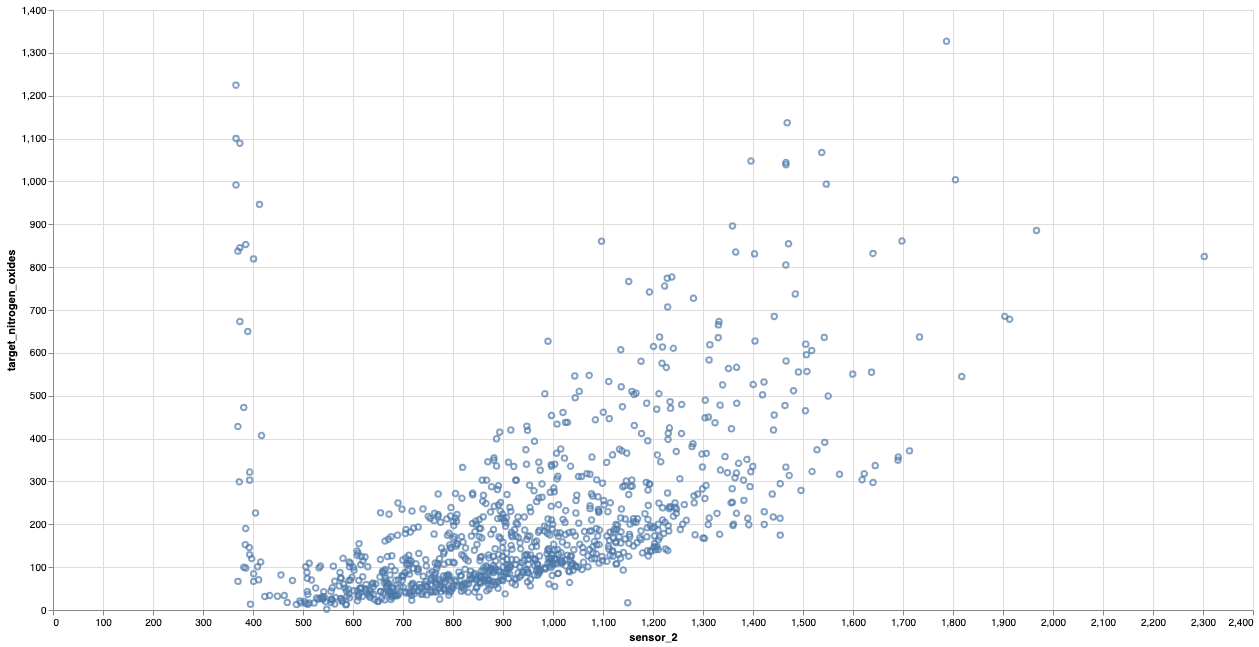

In the next plots, you can click and drag (within any of the plots) to choose a new rectangular region.  We're only showing 1000 of our 5000 training points to keep the image file size a little smaller.

In [ ]:
target = 'target_nitrogen_oxides'

x_bounds = (250,450)
y_bounds = (70,1400)

brush = alt.selection_interval(empty='none',init={'x':x_bounds,'y':y_bounds}) 
base = alt.Chart(df_train.iloc[:1000]).mark_point().encode(
    color=alt.condition(brush,alt.value('red'),alt.value('blue')),
    opacity=alt.condition(brush,alt.value(0.7),alt.value(0.1))
).add_selection(brush).properties(
    width=200,
    height=200
)

charts = {(i,j):base.encode(x = 'sensor_'+str(i), y=j) for i in range(1,6) for j in tar_cols}
date_charts = [base.encode(x = 'date_time:T', y = t+':Q') for t in tar_cols]

text_chart = alt.Chart(df_train.iloc[:1000]).transform_filter(brush).mark_text(size=24, baseline = 'top').encode(
        text=alt.Text('count():Q')
    ).properties(
        width = 200,
        height = 200,
        title="Number of points selected"
    )

alt.vconcat(charts[(2,target)],
            alt.hconcat(text_chart, base.encode(x = 'date_time:T', y = target),
                        *[base.encode(x = p, y=target) for p in ['deg_C','relative_humidity','absolute_humidity']]
                       ),
            alt.hconcat(*[charts[(i,target)] for i in range(1,6)])
           )

The red points seem to follow a quite different pattern from the blue points.  The sensor_2 values for these points are all in the range 250 to 450, but that information isn't enough to identify the red points, because if we select all the points with sensor_2 in the range from 250 to 450, we will also select many "non-outlier" points.<br><br>In the next cell, we zoom in on the range 250 < sensor_2 < 450.<br><br>You can click and drag to choose a new rectangular region.  These next interactions are faster because we use fewer points.

In [ ]:
target = 'target_nitrogen_oxides'

x_bounds = (250,450)
y_bounds = (70,1400)

df_sub = df_train.query('sensor_2 < @x_bounds[1]')

brush = alt.selection_interval(empty='none',init={'x':x_bounds,'y':y_bounds}) 
base = alt.Chart(df_sub).mark_circle().encode(
    color=alt.condition(brush,alt.value('red'),alt.value('blue'))
).add_selection(brush).properties(
    width=250,
    height=220
)

full_charts = [alt.Chart(pd.concat([df_sub,df_train.iloc[:500]])).mark_point().encode(
                x = "sensor_2",
                y = t,
                color=alt.condition(brush,alt.value('red'),alt.value('blue'))
                ).properties(
                    width=250,
                    height=220
                ).add_selection(brush) for t in tar_cols[::-1]]

charts = {(i,j):base.encode(x = 'sensor_'+str(i), y=j) for i in range(1,6) for j in tar_cols}


alt.vconcat(alt.hconcat(charts[(2,target)], *full_charts),
                alt.hconcat(*[base.encode(x="sensor_2:Q", y=p) 
                                          for p in ["date_time","deg_C","relative_humidity","absolute_humidity"]]),
                alt.hconcat(*[base.encode(x = 'sensor_2:Q', y=p) for p in ["sensor_1","sensor_3","sensor_4","sensor_5"]])
            )

It seems like choosing 250 < sensor_2 < 450 and 20 < deg_C < 30 does a good job of identifying these outliers.  Below we will see if we can pick the outlier points out in a more automated manner.
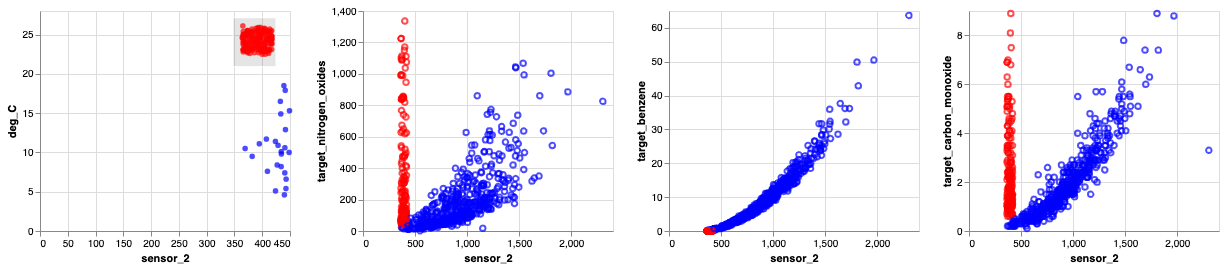

Here is the code for the above images.  You can click and drag to choose a new region.

In [ ]:
brush = alt.selection_interval(empty='none',init={'x':x_bounds,'y':(20,30)}) 
base = alt.Chart(df_sub).mark_circle().encode(
    color=alt.condition(brush,alt.value('red'),alt.value('blue'))
).add_selection(brush).properties(
    width=250,
    height=220
)

full_charts = [alt.Chart(pd.concat([df_sub,df_train.iloc[:500]])).mark_point().encode(
                x = "sensor_2",
                y = t,
                color=alt.condition(brush,alt.value('red'),alt.value('blue'))
                ).properties(
                    width=250,
                    height=220
                ).add_selection(brush) for t in tar_cols[::-1]]

alt.hconcat(base.encode(x="sensor_2:Q", y = "deg_C"), *full_charts)

### What's one way to find the sensor_2 bounds for these outlier points?
This is kind of a weird section.  I wanted to find a "robust" way to get the < 450 bound I was using above.  I'm not satisfied with my method, but at least it shows an example of drawing horizontal and vertical lines (called "rules") in Altair.

How can we locate these outliers, at least their positions along the sensor_2 axis?  What stands out is that many of the target_nitrogen_oxides values are so much higher than you would expect.  (Of course we can't use that quantity on the test.csv file, since we will not know the target values.)  Let's collect some data on how these nitrogen oxides values relate to the sensor_2 values.

In [ ]:
prec = 10
m0 = int(np.floor(min(df_train["sensor_2"])/prec) * prec)
m1 = int(np.floor(max(df_train["sensor_2"])/prec) * prec)

def find_max_in_range(df,var0,var1,lbound,rbound):
    try:
        return max(df.loc[df[var0].between(lbound,rbound),var1])
    except:
        return np.nan

df_max = pd.DataFrame({"sensor_start" : list(range(m0,m1,prec)), 
                       "max_nitrogen":[find_max_in_range(df_train,"sensor_2","target_nitrogen_oxides",i,i+prec) for i in range(m0,m1,prec)]})
df_max.dropna(inplace=True)

Here we show two charts:  
* the first shows all data points
* the second shows only the max target_nitrogen_oxides values for width-10 intervals.

In [ ]:
chart_all = alt.Chart(df_train).mark_circle(size=100).encode(
                x = "sensor_2",
                y = "target_nitrogen_oxides",
                tooltip = ["sensor_2"],
).properties(width=500)

chart_max = alt.Chart(df_max).mark_circle(size=100).encode(
    x = "sensor_start",
    y = "max_nitrogen",
    tooltip = ["sensor_start"],
).properties(width=500)

chart_all | chart_max

Here is one visual way to identify the upper-left cluster:  
The sensor_start values are in the lowest quantile and the max_nitrogen values are above the median. (I checked and using median for both would not work.)  Having to convert the quantile value to a string feels weird; did I do something wrong?

In [ ]:
xq = df_max["sensor_start"].quantile(.2)

rule_x = alt.Chart(df_max).mark_rule(color='red').encode(
    x='a:Q'
).transform_calculate(
    a=str(xq)
)

rule_y = alt.Chart(df_max).mark_rule(color='red').encode(
    y = 'median(max_nitrogen):Q'
)

chart_max+rule_x+rule_y

In [ ]:
# Here are the corresponding values.
df_upper_left = df_max[(df_max["sensor_start"] < xq) & (df_max["max_nitrogen"] > np.median(df_max["max_nitrogen"]))]
df_upper_left

We'll use a corresponding value as our cutoff.  Recall that the sensor_start values correspond to width-10 intervals.  It feels pretty ad hoc to me.<br><br>Notice how much the maximum drops as we approach this cutoff.

In [ ]:
sensor_2_cutoff = max(df_upper_left["sensor_start"]) + 3*prec
df_temp = df_max[(df_max["sensor_start"] < sensor_2_cutoff)]
df_temp

### Can we identify these same points using K-Means clustering?

The main point of this section is to produce similar pictures to what we had above, but without using any of the target values.  This will give a method for identifying the similar outliers on the test data.

My first attempt, without using anything that we learned above, did not work.
Probably there is some clustering algorithm other than K-Means which would work better.

In [ ]:
df_cluster = df_train.iloc[:,1:].copy() #ignore the date_time column.

kmeans = KMeans(n_clusters=2).fit(df_cluster)
df_cluster["cluster"] = kmeans.predict(df_cluster)

alt.Chart(df_cluster.iloc[:1000]).mark_point().encode(
    x='sensor_2',
    y='target_nitrogen_oxides',
    color='cluster:N'
).properties(
    width=800,
    height=400
)

What if we try to restrict our attention to a smaller amount of the data, using the sensor_2 bound we found above and a subsest of the columns.  I chose these four columns by looking at the above images and asking which images most clearly related to the outlier points. Overall I think I did these steps just to practice with K-Means.

In [ ]:
df_cluster = df_train.copy() # make a copy because I'm going to include a new cluster column.
cols = ["sensor_2","deg_C","sensor_1","sensor_5"]
mask = (df_cluster["sensor_2"] < sensor_2_cutoff)
kmeans = KMeans(n_clusters=2).fit(df_cluster.loc[mask, cols])
df_cluster.loc[mask, "cluster"] = kmeans.predict(df_cluster.loc[mask, cols])

There are two main things to notice in the next pictures:
* The clusters aren't at all obvious in the full pictures (nor in the zoomed in nitrogen_oxides chart)
* The clusters are pretty obvious if we zoom in to our small sensor_2 range and look at the correct axes.

In [ ]:
def make_row(df,ycols):
    return alt.hconcat(*[alt.Chart(df).mark_circle().encode(
            alt.X("sensor_2:Q",        
                ),
            y=c,
            color = alt.Color("cluster:N",scale=alt.Scale(scheme="accent"))
            ).properties(
                width=240,
                height=240
            ) for c in ycols])

target = "target_nitrogen_oxides"
alt.vconcat(make_row(df_cluster.iloc[:1500],[target]+cols[1:]),make_row(df_cluster.loc[mask],[target]+cols[1:]))

In the small region where we labeled clusters, almost all the points would be considered "outliers" in the full region. The zeroth entry in the index is the corresponding outlier label.

In [ ]:
print(df_cluster["cluster"].value_counts())
c_outlier = df_cluster["cluster"].value_counts().index[0]
c_main = 1-c_outlier

Let's write a function that provides a cluster label for a dataset using the above K-Means. It only works with the specific columns, etc chosen, so this is not a very robust function.

We artificially put everything outside of our sensor_2 interval into the "main" cluster.  Put everything outside that interval in the "main" cluster
    


In [ ]:
def write_cluster(df):
    temp_series = pd.Series(dict(zip(df.index,kmeans.predict(df.loc[:,cols]))))
    temp_series.loc[df["sensor_2"] >= sensor_2_cutoff] = c_main
    return temp_series

These next pictures look very similar to what we had above, but notice that the coloring here was done without ever using the target values.

In [ ]:
df_chart = df_train.copy()
df_chart["cluster"] = write_cluster(df_chart)

alt.Chart(df_chart.iloc[:1000]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative',scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color = alt.condition(alt.datum.cluster == c_main, alt.value("blue"), alt.value("red")),
    opacity = alt.condition(alt.datum.cluster == c_main, alt.value(0.1),alt.value(0.7))
).properties(
    width=200,
    height=200
).repeat(
    row=tar_cols,
    column=pred_cols
)

Do our points labelled as outliers also stand out in the test data?  (The part we split off from kaggle_train.)

In [ ]:
df_chart = df_test.copy()
df_chart["cluster"] = write_cluster(df_chart)

alt.Chart(df_chart.iloc[:1000]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative',scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color = alt.condition(alt.datum.cluster == c_main, alt.value("blue"), alt.value("red")),
    opacity = alt.condition(alt.datum.cluster == c_main, alt.value(0.1),alt.value(0.7))
).properties(
    width=200,
    height=200
).repeat(
    row=tar_cols,
    column=pred_cols
)

Here are some similar pictures without using the target values on the y-axes.  (We wouldn't be able to make the above pictures on the test.csv file data, but we can make the following pictures on the test.csv data.  We will do that later.)

In [ ]:
alt.Chart(df_chart.iloc[:1000]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color = alt.condition(alt.datum.cluster == c_main, alt.value("blue"), alt.value("red")),
    opacity = alt.condition(alt.datum.cluster == c_main, alt.value(0.1),alt.value(0.7))
).properties(
    width=80,
    height=80
).repeat(
    row=pred_cols[1:9],
    column=pred_cols[1:9]
)

### Gradient boosting application
I don't know much about this technique.  I saw it in [Amitesh Gangrade](https://www.kaggle.com/amiteshgangrade)'s notebook [https://www.kaggle.com/amiteshgangrade/average-of-random-forest-and-gradient-boosting/](https://www.kaggle.com/amiteshgangrade/average-of-random-forest-and-gradient-boosting/).

We investigate the question: how does the method perform if we remove the "outliers" before fitting?

In [ ]:
df_train_label = df_train.copy()
df_train_label["cluster"] = write_cluster(df_train_label)
X_train = df_train_label.drop(tar_cols, axis=1).copy()
y_train = df_train_label[tar_cols].copy()

df_test_label = df_test.copy()
df_test_label["cluster"] = write_cluster(df_test_label)
X_test = df_test_label.drop(tar_cols, axis=1).copy()
y_test = df_test_label[tar_cols].copy()

X_train_main = X_train.query("cluster==@c_main").copy()
y_train_main = y_train.loc[X_train_main.index].copy()
X_train_outlier = X_train.query("cluster==@c_outlier").copy()
y_train_outlier = y_train.loc[X_train_outlier.index].copy()

X_test_main = X_test.query("cluster==@c_main").copy()
y_test_main = y_test.loc[X_test_main.index].copy()
X_test_outlier = X_test.query("cluster==@c_outlier").copy()
y_test_outlier = y_test.loc[X_test_outlier.index].copy()

In [ ]:
loss_dictionary = {(i,j):{} for i in ["main","outlier"] for j in ["with","without"]}

for t in tar_cols:
    regr = GradientBoostingRegressor()
    regr.fit(X_train_main, y_train_main[t])
    pred = regr.predict(X_test_main)
    pred[pred < 0] = 0
    loss_dictionary[("main","with")][t] = np.sqrt(mean_squared_log_error(pred.reshape(-1,1), y_test_main[t].to_numpy().reshape(-1,1)))
    regr = GradientBoostingRegressor()
    regr.fit(X_train_outlier, y_train_outlier[t])
    pred = regr.predict(X_test_outlier)
    pred[pred < 0] = 0
    loss_dictionary[("outlier","with")][t] = np.sqrt(mean_squared_log_error(pred.reshape(-1,1), y_test_outlier[t].to_numpy().reshape(-1,1)))
    regr = GradientBoostingRegressor()
    regr.fit(X_train.drop("cluster",axis=1).copy(), y_train[t])
    pred = regr.predict(X_test_main.drop("cluster",axis=1).copy())
    pred[pred < 0] = 0
    loss_dictionary[("main","without")][t] = np.sqrt(mean_squared_log_error(pred.reshape(-1,1), y_test_main[t].to_numpy().reshape(-1,1)))
    pred = regr.predict(X_test_outlier.drop("cluster",axis=1).copy())
    pred[pred < 0] = 0
    loss_dictionary[("outlier","without")][t] = np.sqrt(mean_squared_log_error(pred.reshape(-1,1), y_test_outlier[t].to_numpy().reshape(-1,1)))

In [ ]:
triples = product(["main","outlier"],["with","without"],tar_cols)
df_results = pd.DataFrame([{"data":t[0],"method":t[1]+" cluster labels","target":t[2],"loss":loss_dictionary[(t[0],t[1])][t[2]]} for t in triples])

The next pictures suggest this method performs great on the outliers, but in my file submissions that has not seemed to be the case.

In [ ]:
def show_losses(label):
    c = alt.Chart(df_results[df_results["data"] == label]).mark_bar().encode(
        x='method:N',
        y='loss:Q',
        color='method:N',
        column=alt.Column('target:N',spacing=90, title=""),
        tooltip='loss'
    ).properties(
        width = 50,
        title = alt.TitleParams(text = ["Comparison of losses on the " + label + " data","GradientBoostingRegressor"],anchor="middle",offset=10),
    )
    return c


alt.hconcat(show_losses("main"), show_losses("outlier")).properties(spacing=100).configure_title(
    align='center'
)

### RandomForestRegressor
There's minimal or no noticeable improvement using our clusters with RandomForestRegressor

In [ ]:
loss_dictionary = {(i,j):{} for i in ["main","outlier"] for j in ["with","without"]}

for t in tar_cols:
    regr = RandomForestRegressor()
    regr.fit(X_train_main, y_train_main[t])
    pred = regr.predict(X_test_main)
    pred[pred < 0] = 0
    loss_dictionary[("main","with")][t] = np.sqrt(mean_squared_log_error(pred.reshape(-1,1), y_test_main[t].to_numpy().reshape(-1,1)))
    regr = RandomForestRegressor()
    regr.fit(X_train_outlier, y_train_outlier[t])
    pred = regr.predict(X_test_outlier)
    pred[pred < 0] = 0
    loss_dictionary[("outlier","with")][t] = np.sqrt(mean_squared_log_error(pred.reshape(-1,1), y_test_outlier[t].to_numpy().reshape(-1,1)))
    regr = RandomForestRegressor()
    regr.fit(X_train.drop("cluster",axis=1).copy(), y_train[t])
    pred = regr.predict(X_test_main.drop("cluster",axis=1).copy())
    pred[pred < 0] = 0
    loss_dictionary[("main","without")][t] = np.sqrt(mean_squared_log_error(pred.reshape(-1,1), y_test_main[t].to_numpy().reshape(-1,1)))
    pred = regr.predict(X_test_outlier.drop("cluster",axis=1).copy())
    pred[pred < 0] = 0
    loss_dictionary[("outlier","without")][t] = np.sqrt(mean_squared_log_error(pred.reshape(-1,1), y_test_outlier[t].to_numpy().reshape(-1,1)))

In [ ]:
triples = product(["main","outlier"],["with","without"],tar_cols)
df_results = pd.DataFrame([{"data":t[0],"method":t[1]+" cluster labels","target":t[2],"loss":loss_dictionary[(t[0],t[1])][t[2]]} for t in triples])

In [ ]:
def show_losses(label):
    c = alt.Chart(df_results[df_results["data"] == label]).mark_bar().encode(
        x='method:N',
        y='loss:Q',
        color='method:N',
        column=alt.Column('target:N',spacing=90, title=""),
        tooltip='loss'
    ).properties(
        width = 50,
        title = alt.TitleParams(text = ["Comparison of losses on the " + label + " data","RandomForestRegressor"],anchor="middle",offset=10),
    )
    return c


alt.hconcat(show_losses("main"), show_losses("outlier")).properties(spacing=100).configure_title(
    align='center'
)

### File creation
We generate two files, both using GradientBoostingRegressor: A baseline file without cluster labels, and a second file with cluster labels.  I tried miscellaneous alterations hoping one of them would perform especially well.  (I didn't notice much correlation between what performed well on my personal test set (from train.csv) and what performed well when submitted to Kaggle.)

In [ ]:
# Same as above, except using the entire train.csv file.
df_train_label = kaggle_train.copy()
df_train_label["cluster"] = write_cluster(df_train_label)
X_train = df_train_label.drop(tar_cols, axis=1).copy()
y_train = df_train_label[tar_cols].copy()

X_test = kaggle_test.copy()
X_test["cluster"] = write_cluster(X_test)

X_train_main = X_train.query("cluster==@c_main").copy()
y_train_main = y_train.loc[X_train_main.index].copy()
X_train_outlier = X_train.query("cluster==@c_outlier").copy()
y_train_outlier = y_train.loc[X_train_outlier.index].copy()

X_test_main = X_test.query("cluster==@c_main").copy()
X_test_outlier = X_test.query("cluster==@c_outlier").copy()

Recall that our cluster stood out when zoomed in on our training data:

In [ ]:
# From the training data
mask = (X_train["sensor_2"] < sensor_2_cutoff)
alt.vconcat(make_row(X_train.iloc[:1500],["deg_C","sensor_1","sensor_5"]),
            make_row(X_train.loc[mask],["deg_C","sensor_1","sensor_5"]))

It's reassuring that our supposed cluster also stands out when plotted on the data from test.csv.

In [ ]:
# On the Kaggle test.csv data
mask = (X_test["sensor_2"] < sensor_2_cutoff)
alt.vconcat(make_row(X_test.iloc[:1500],["deg_C","sensor_1","sensor_5"]),
            make_row(X_test.loc[mask],["deg_C","sensor_1","sensor_5"]))

Here is another view, still on the test data.

In [ ]:
alt.Chart(X_test.iloc[:1000]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color = alt.condition(alt.datum.cluster == c_main, alt.value("blue"), alt.value("red")),
    opacity = alt.condition(alt.datum.cluster == c_main, alt.value(0.1),alt.value(0.7))
).properties(
    width=80,
    height=80
).repeat(
    row=pred_cols[1:9],
    column=pred_cols[1:9]
)

Baseline file, without using the cluster label.
* Loss score: 0.23936

In [ ]:
df_submit_baseline = df_submit.copy()

for t in tar_cols:
    regr = GradientBoostingRegressor()
    regr.fit(X_train.drop("cluster",axis=1), y_train[t])
    pred = regr.predict(X_test.drop("cluster",axis=1))
    pred[pred < 0] = 0
    df_submit_baseline[t] = pred

Midway file, where we make no changes other than to include the cluster label when training.  It performs slightly worse!  (Whenever I get such results, I wonder if I made a mistake somewhere.)

* Loss score: 0.24136

In [ ]:
df_submit_cluster = df_submit.copy()

for t in tar_cols:
    regr = GradientBoostingRegressor()
    regr.fit(X_train, y_train[t])
    pred = regr.predict(X_test)
    pred[pred < 0] = 0
    df_submit_cluster[t] = pred

Here we evaluate our main test data using only the main training data.  For the outlier data, looking back at our above images, it seemed like the outliers were most extreme with regards to the sensor columns and the absolute humidity column, so we remove those before training.  (The performance seems to be worse if we train only using the outliers from the training set.)

* Loss score: 0.20728

In [ ]:
df_submit_GBR = df_submit.copy()

drop_cols = [f"sensor_{i}" for i in range(1,6)] + ["absolute_humidity"]

for t in tar_cols:
    regr = GradientBoostingRegressor()
    regr.fit(X_train_main, y_train_main[t])
    pred = regr.predict(X_test_main)
    pred[pred < 0] = 0
    df_submit_GBR.loc[X_test_main.index,t] = pred
    regr = GradientBoostingRegressor()
    regr.fit(X_train.drop(drop_cols,axis=1), y_train[t])
    pred = regr.predict(X_test_outlier.drop(drop_cols,axis=1))
    pred[pred < 0] = 0
    df_submit_GBR.loc[X_test_outlier.index,t] = pred

In [ ]:
df_submit_baseline.to_csv("submit_baseline.csv", index=False)
df_submit_cluster.to_csv("submit_cluster.csv", index=False)
df_submit_GBR.to_csv("submit_GBR.csv", index=False)

Here you can see the output differences for our two methods.  I only show part of the data to make it easier to read.

In [ ]:
df0 = df_submit_baseline.drop("date_time",axis=1).copy()
df1 = df_submit_GBR.drop("date_time",axis=1).copy()

df0.columns = ["GBR Baseline " + t for t in tar_cols]
df1.columns = ["GBR with clusters " + t for t in tar_cols]

df_merged = pd.merge(df0,df1,left_index=True,right_index=True)
df_merged = df_merged.reset_index()

alt.vconcat(*[
alt.Chart(df_merged.iloc[::17]).transform_fold(
    [c for c in df_merged.columns if t in c],
).mark_circle().encode(
    x='index:Q',
    y='value:Q',
    color='key:N',
    tooltip=['key:N','value:Q','index:Q']
).properties(
    title=t,
    width=1000
) for t in tar_cols]).resolve_scale(color='independent')